In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# zip 파일을 위한 모듈
import os
import io
import zipfile
from zipfile import ZipFile

In [2]:
# open할 데이터 파일
!ls ../data/

open.zip  test.csv  train.csv


In [2]:
# 압축된 파일들의 리스트 확인하기
with ZipFile('../data/open.zip','r') as zipObj:
    listOfFileNames = zipObj.namelist()
    for fileName in listOfFileNames:
        print(fileName)

sample_submission.csv
test.csv
train.csv


In [3]:
# 특정 파일만 압축풀기
with ZipFile('../data/open.zip','r') as zipObj:
    list_filenames = zipObj.namelist()
    for filename in list_filenames:
        if filename in ['train.csv','test.csv']:
            zipObj.extract(filename, '..'+os.path.sep+'data'+os.path.sep)

In [5]:
!ls ../data/

open.zip  test.csv  train.csv


In [4]:
train = pd.read_csv('../data/train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('../data/test.csv').drop(columns=['SAMPLE_ID'])

In [5]:
train.head()

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ID                  391939 non-null  object 
 5   BREADTH             391938 non-null  float64
 6   BUILT               391939 non-null  int64  
 7   DEADWEIGHT          391939 non-null  int64  
 8   DEPTH               391938 non-null  float64
 9   DRAUGHT             391938 non-null  float64
 10  GT                  391939 non-null  int64  
 11  LENGTH              391938 non-null  float64
 12  SHIPMANAGER         391939 non-null  object 
 13  FLAG                391939 non-null  object 
 14  U_WIND              228251 non-null  float64
 15  V_WIND              228251 non-nul

### Data Pre-Processing
- datetime 컬럼을 여러 파생 변수(연, 월, 일, 시, 분, 요일) 로 변환한다.
- Categorical(범주형) 컬럼을 인코딩한다.

In [5]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
#     df['minute'] = df['ATA'].dt.minute
#     df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

In [ ]:
# Categorical 컬럼 인코딩
from sklearn.preprocessing import LabelEncoder
import bisect

categorical_features = ['ARI','SHIP_TYPE_CATEGORY']

le = LabelEncoder()
for df in [train, test]:    
    # ARI_CO + ARI_PO = ARI
    df['ARI']=df['ARI_CO']+df['ARI_PO']
    df.drop(columns=['ARI_CO','ARI_PO'],axis=1,inplace=True)

    # drop useless features
    df.drop(columns=['ID','SHIPMANAGER','FLAG'],axis=1,inplace=True)

    # encode
    for feature in categorical_features:
        df[feature] = le.fit_transform(df[feature].astype(str))
        


In [7]:
# Categorical 컬럼 인코딩
# from sklearn.preprocessing import LabelEncoder
# import bisect
# from tqdm import tqdm

# categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
# encoders = {}

# for feature in tqdm(categorical_features, desc="Encoding features"):
#     le = LabelEncoder()
#     train[feature] = le.fit_transform(train[feature].astype(str))
#     le_classes_set = set(le.classes_)
#     test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
#     le_classes = le.classes_.tolist()
#     bisect.insort_left(le_classes, '-1')
#     le.classes_ = np.array(le_classes)
#     test[feature] = le.transform(test[feature].astype(str))
#     encoders[feature] = le

Encoding features: 100%|████████████████████████████████████████████| 6/6 [00:00<00:00,  7.18it/s]


In [8]:
# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

In [9]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
0,17,21,2,30.881018,24710,30.0,24,24300,10.0,10.0,...,2.706992,5,0.002615,3.450000,2018,12,17,21,29,0
1,7,81,0,0.000000,23140,30.0,13,35900,10.0,10.0,...,2.706992,12,0.000217,0.000000,2014,9,23,6,59,1
2,4,14,2,0.000000,19009,50.0,12,146000,30.0,20.0,...,2.706992,6,0.001614,0.000000,2015,2,3,22,0,1
3,8,101,2,0.000000,24048,20.0,18,6910,10.0,10.0,...,2.629350,13,0.000356,0.000000,2020,1,17,4,2,4
4,17,21,2,27.037650,911,50.0,10,116000,20.0,10.0,...,2.495953,15,0.002615,253.554444,2020,1,26,7,51,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391934,8,66,2,0.000000,23490,20.0,27,6820,10.0,10.0,...,2.706992,14,0.000552,0.000000,2017,6,6,5,2,1
391935,17,21,0,5.884603,10196,10.0,12,3160,10.0,10.0,...,1.253491,8,0.002615,144.061389,2019,10,16,0,36,2
391936,21,61,0,70.660241,8823,30.0,8,60300,20.0,10.0,...,4.766257,18,0.000155,41.482222,2021,3,23,22,35,1
391937,19,35,2,9.448179,9246,30.0,29,23800,10.0,10.0,...,2.706992,15,0.000990,7.485278,2015,1,8,7,15,3


## EDA (Exploratory Data Analysis)

#### 상관분석

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

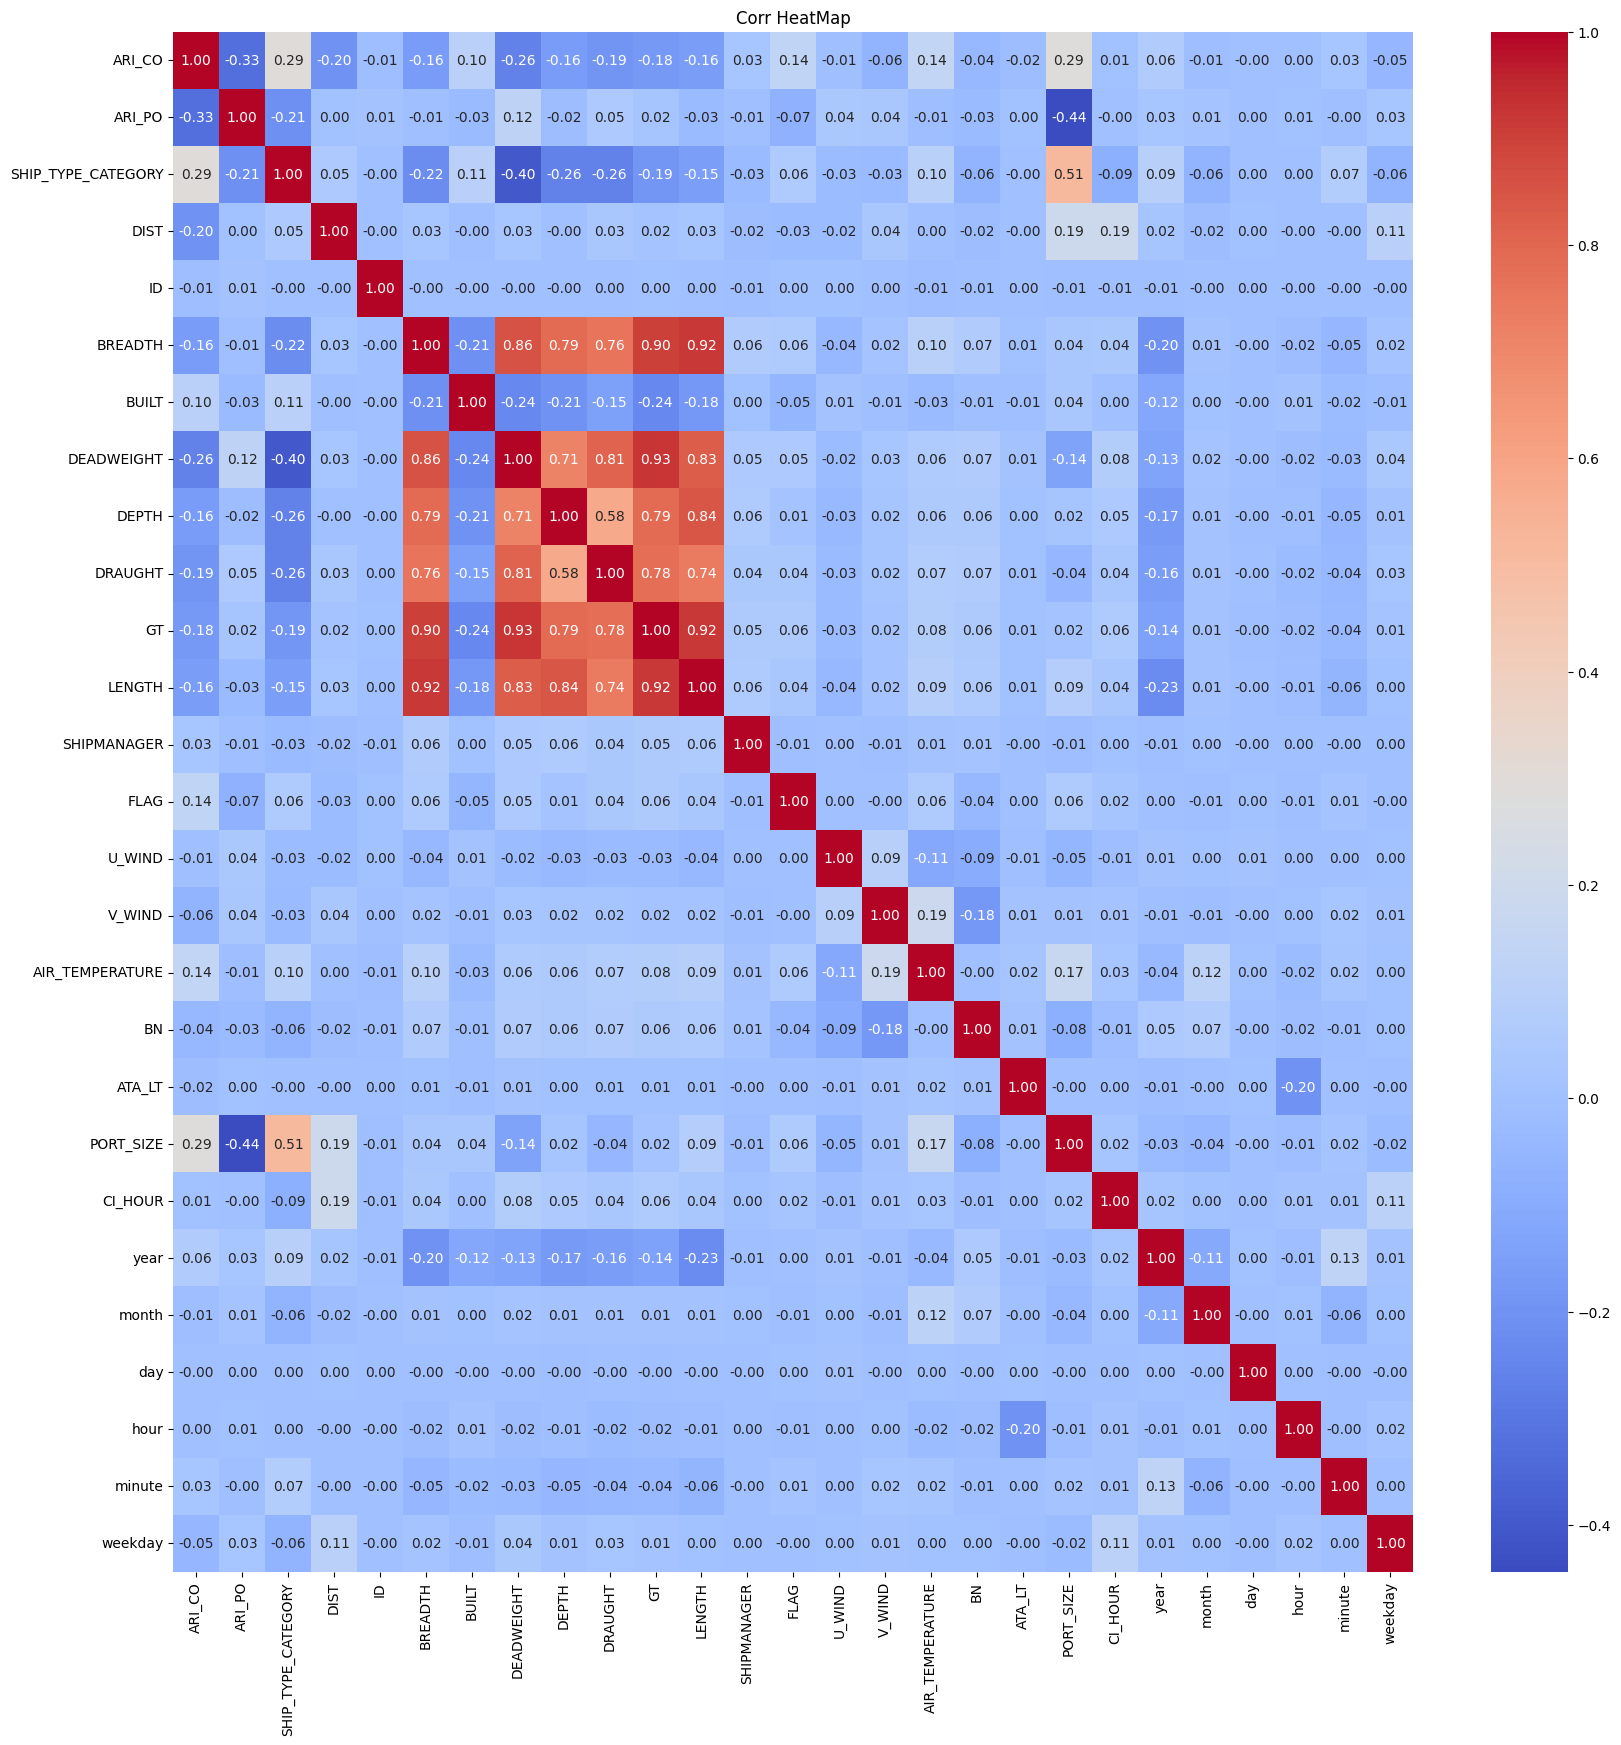

In [11]:
# df로부터 '상관계수 행렬'을 구한다.
train_correlation_matrix = train.corr()
# 상관관계를 시각화한다.
plt.figure(figsize=(20, 20))
sns.heatmap(train_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corr HeatMap")
plt.savefig('HD_ship_Corr.png',dpi=300)
plt.show()

In [ ]:
X=train['ARI_CO','ARI_PO','SHIP_TYPE_CATEGORY','DIST','BREADTH','BUILT',]
